## Experimenting and Visualize the DFT
In the next cells i played around a bit with the 2-Dimensional FFT from Numpy and some Images.

The Fourier transform converts images from spatial domain (pixels) to frequency domain (sinusoidal components).

### Properties

1. **Decomposition**
  - Low frequencies: Gradual changes (background)
  - High frequencies: Rapid changes (edges)

2. **Separability**
  - 2D transform = 1D transform on rows, then columns

3. **Shift Theorem**
  - Spatial shift in the space domain results in Phase change in frequency domain

4. **Rotation**
  - Image rotation results in Equal rotation in frequency domain

5. **Parseval's Theorem**
  - Energy conserved between spatial and frequency domains

### Visualizing the Magnitude Spectrum of a Circle

Change radius to adjust the size of the circle.
The dark colors in the Frequency domain plot are frequencies that are not part of the circle-image and the bright yellow parts are the frequencies wof waves with a high amplitude.

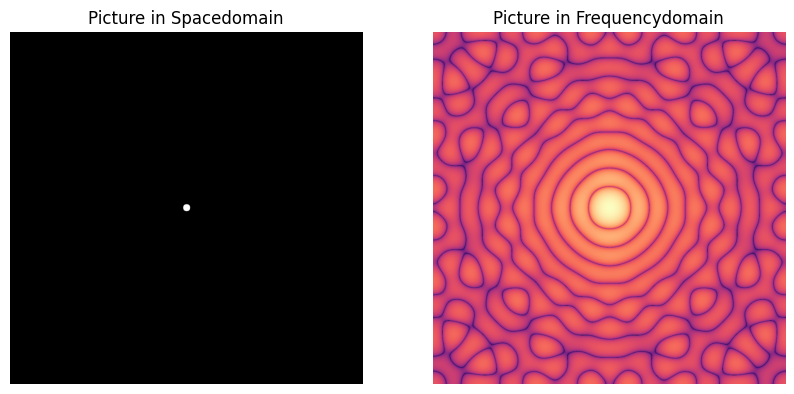

In [25]:
import random as rand
import numpy as np
import matplotlib.pyplot as plt


pixel_list = [0,255]
hoehe = 1000
breite = 1000

circle = np.zeros((breite,hoehe), dtype=np.uint8)
# ---
radius = 10
# ---
# Kreis zeichnen
for x in range(breite):
    for y in range(hoehe):
        if ((x - breite/2) * (x - breite/2) + (y - hoehe/2) * (y - hoehe/2) <= radius * radius):
            circle[x][y] = 255

# fft anwenden
fft_pic = np.fft.fft2(circle)
fft_pic_shifted = np.fft.fftshift(fft_pic)
magnitude_spectrum = np.log(np.abs(fft_pic_shifted)+1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.title('Picture in Spacedomain')


plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='magma')
plt.axis('off')
plt.title('Picture in Frequencydomain')


plt.show()

#### 3D Plot of the Frequencydomain 

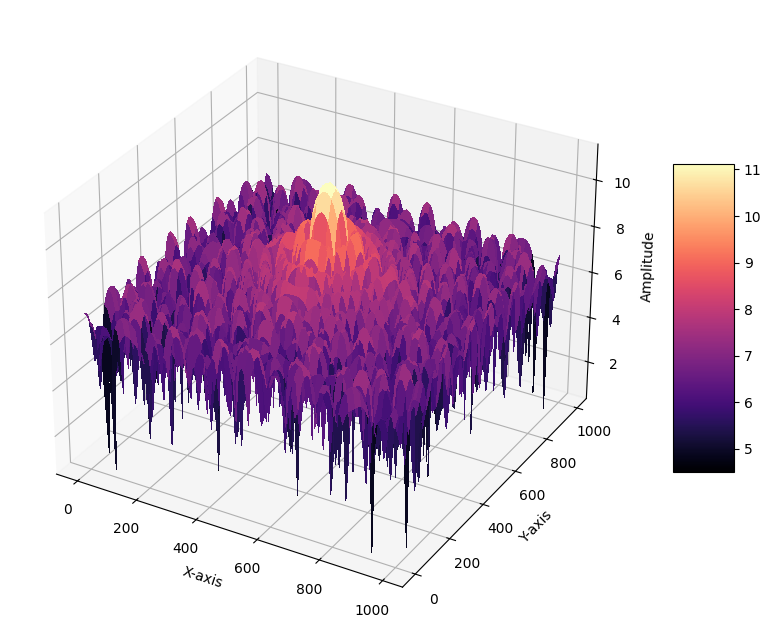

In [26]:
from mpl_toolkits import mplot3d
X = np.arange(breite)
Y = np.arange(hoehe)
X, Y = np.meshgrid(X, Y)
Z = magnitude_spectrum

downsample_factor = 10  # Adjust this value as needed
X_ds = X[::downsample_factor, ::downsample_factor]
Y_ds = Y[::downsample_factor, ::downsample_factor]
Z_ds = Z[::downsample_factor, ::downsample_factor]


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_ds, Y_ds, Z_ds, cmap='magma', linewidth=0, antialiased=False)


# Customize the axes and color bar
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Amplitude')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



## Frequency Domain of Example Picture

This is how the example picture looks in the colorized frequency domain. <br>


(400, 300)
(400, 300)


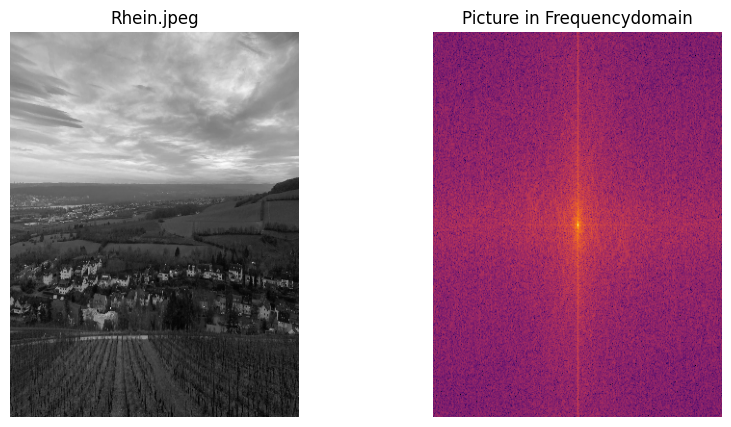

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trp
import sys

path = 'Rhein.jpeg'
image_BGR = cv2.imread(path)
img = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
resized = cv2.resize(grey,(300,400))



# DFT auf das Bild anwenden
f_transform = np.fft.fft2(resized)
f_transform_shifted = np.fft.fftshift(f_transform)
print(f_transform_shifted.shape)
# Magnitude Spektrum berechnen
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
print(magnitude_spectrum.shape)
# Bild und Frequenzspektrum anzeigen
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(resized, cmap='gray')
plt.title(f'{path}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='inferno')
plt.title('Picture in Frequencydomain')
plt.axis('off')

plt.show()

## Understanding Wave Composition of a Picture in Spacedomain

The Code below breakes down the frequencies of the picture, sorts them and reconstructs the

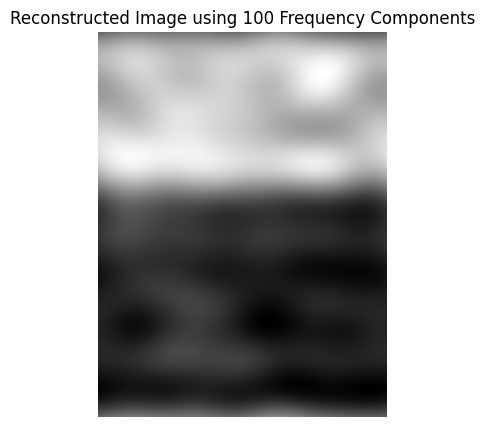

(np.float64(-0.5), np.float64(299.5), np.float64(399.5), np.float64(-0.5))

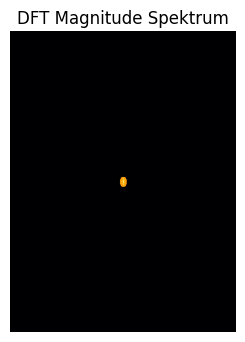

In [31]:
import numpy as np
import matplotlib.pyplot as plt


rows, cols = resized.shape

# Step 1: Compute the 2D FFT and shift
f_transform = np.fft.fft2(resized)
f_transform_shifted = np.fft.fftshift(f_transform)

# Step 2: Get frequency components
fx = np.fft.fftfreq(cols)
fy = np.fft.fftfreq(rows)
fx_shifted = np.fft.fftshift(fx)
fy_shifted = np.fft.fftshift(fy)
FX, FY = np.meshgrid(fx_shifted, fy_shifted)

# Step 3: get frequencyy, amplitude and phase
freq_magnitude = np.sqrt(FX**2 + FY**2)
amplitude = np.abs(f_transform_shifted)
phase = np.angle(f_transform_shifted)

# Flatten the arrays
freq_magnitude_flat = freq_magnitude.flatten()
amplitude_flat = amplitude.flatten()
phase_flat = phase.flatten()
FX_flat = FX.flatten()
FY_flat = FY.flatten()

# Sort by frequency magnitude
sorted_indices = np.argsort(freq_magnitude_flat)
freq_magnitude_flat = freq_magnitude_flat[sorted_indices]
amplitude_flat = amplitude_flat[sorted_indices]
phase_flat = phase_flat[sorted_indices]
FX_flat = FX_flat[sorted_indices]
FY_flat = FY_flat[sorted_indices]

# Step 4: Initialize the reconstructed image
img_reconstructed = np.zeros((rows, cols))

# Step 5: Add up waves for a limited number of frequency components
'''
chose how many frequency components are needed to reconstruct the image. 
Those are sorted in ascending order, so num_components = 100 selects just the 100 lowest frequencies of the picture
'''
num_components = 100 # Adjust this number based on computational capacity
x = np.arange(cols)
y = np.arange(rows)
X_grid, Y_grid = np.meshgrid(x, y)

for i in range(num_components):
    amp = amplitude_flat[i]
    ph = phase_flat[i]
    fx = FX_flat[i]
    fy = FY_flat[i]
    
    # Generate the specific wave
    wave = amp * np.cos(2 * np.pi * (fx * X_grid + fy * Y_grid) + ph)
    
    # Add the wave to the reconstructed image
    img_reconstructed += wave

# Step 6: Normalize the reconstructed image
img_reconstructed /= num_components

# take the fft of reconstructed picture
fft_of_image =  np.fft.fft2(img_reconstructed)
fft_of_image_shifted = np.fft.fftshift(fft_of_image)

# Display the reconstructed image in spacedomain(left) and frequencydomain(right)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_reconstructed, cmap='gray')
plt.title(f'Reconstructed Image using {num_components} Frequency Components')
plt.axis('off')
plt.show()

plt.subplot(1, 2, 2)
plt.imshow(np.log(abs(fft_of_image_shifted)+1), cmap='inferno')
plt.title('DFT Magnitude Spektrum')
plt.axis('off')